In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/brdd/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    
import functions_metrics as fm
import functions_read_data as rdat
import function_model_definition as md
import functions_gradcam as gc
import functions_plot_heatmap as fph

/tf


## Load Data

In [3]:
# Define the path + output path:
DATA_DIR = DIR + "data/"

version = "10Fold_sigmoid_V3" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False

# Define Model Version
model_version = 1

if version.startswith("10Fold"):
    WEIGHT_DIR = DIR + "weights/" + version + "/"
    OUTPUT_DIR = DIR + "pictures/" + version + "/"
    pic_save_name = "10Fold_ensembling" + version[6:]
    
elif version == "andrea":
    WEIGHT_DIR = DIR + "weights/andrea_split/"
    OUTPUT_DIR = DIR + "pictures/andrea_split/"
    pic_save_name = "andrea_split"

In [4]:
## load images and ids

if version == "andrea": ## for andrea
    with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
        # with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
        # both images are the same
            X_in = h5["X"][:]
            pat = h5["pat"][:]
            
    # load results
    path_results = DATA_DIR + "all_tab_results_andrea_split.csv" # andrea split
    
elif version.startswith("10Fold"): ## for 10 Fold       
    if version.endswith("V0") or version.endswith("sigmoid"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
        num_models = 5
    elif version.endswith("V1"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V1.csv", sep=",")
        num_models = 10
    elif version.endswith("V2") or version.endswith("V2f"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V2.csv", sep=",")
        num_models = 5
    elif version.endswith("V3"):
        id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V3.csv", sep=",")
        num_models = 5
    pat = id_tab["p_id"].to_numpy()
    X_in = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
    
    # load results
    path_results = DATA_DIR + "all_tab_results_" + version + "_M" + str(model_version) + ".csv" # 10 Fold

all_results = pd.read_csv(path_results, sep=",")
all_results = all_results.sort_values("p_idx")

In [5]:
split_6_pats = [297, 299, 319, 460, 483, 529, 27, 35, 125, 481]

## Model

In [6]:
# define model
input_dim = (128, 128, 28, 1)

if "sigmoid" in version or "andrea_split" in version:
    last_activation = "sigmoid"
    output_dim = 1
    LOSS = "binary_crossentropy"
elif "softmax" in version:
    last_activation = "softmax"
    output_dim = 2
    LOSS = tf.keras.losses.categorical_crossentropy
    
if version.endswith("f"):
    layer_connection = "flatten"
else:
    layer_connection = "globalAveragePooling"

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [7]:
# Define Model Name
def generate_model_name(which_split, model_nr, model_version = model_version, path = WEIGHT_DIR):
    if layer_connection == "globalAveragePooling":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_avg_layer_paper_model_" + last_activation + "_activation_"  + str(model_version) + str(model_nr) + ".h5")
    elif layer_connection == "flatten":
        return (path + "3d_cnn_binary_model_split" + str(which_split) + 
                  "_unnormalized_flat_layer_paper_model_" + last_activation + "_activation_" + str(model_version) + str(model_nr) + ".h5")

# Plot GradCams

## Compare one Model to all Models

In [8]:
# all_results

In [9]:
# select patient
p_ids = [42]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in, 
                                                                 gen_model_name = generate_model_name,
                                                                 num_models = num_models)
res_table

index  p_idx  p_id  mrs  unfavorable  fold0  fold1  fold2 fold3  fold4  \
0     93     32    42  2.0            0  train  train  train  test  train   

   ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
0  ...        0.284154        0.350431        0.307981          0.301949   

  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  \
0         0.301299   0.240781             1    0.030253    0.126957   

   pred_correct  
0         False  

[1 rows x 28 columns]

In [10]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

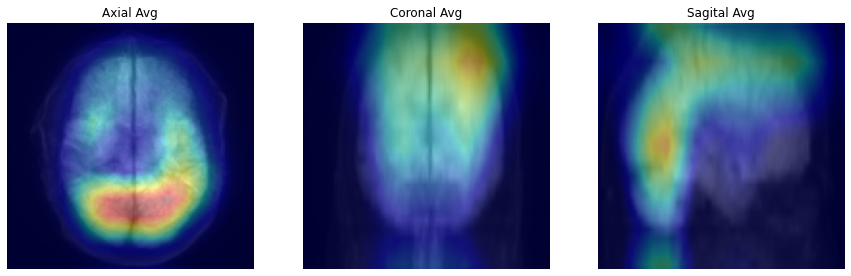

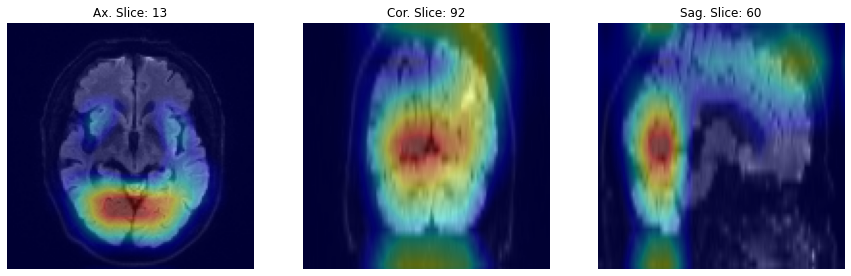

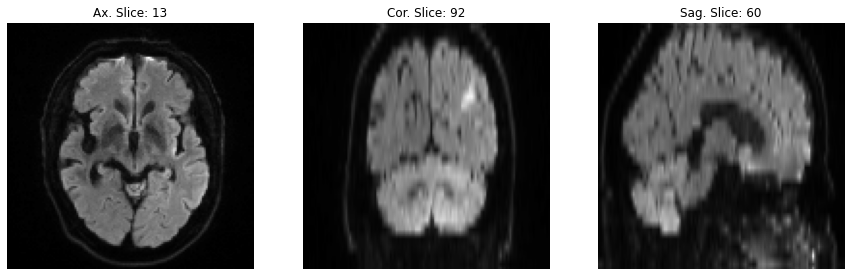

In [11]:
# only one model
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][1]],
    layers = "conv3d_3",
#     layers = vis_layers,
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "last")

fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
fph.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

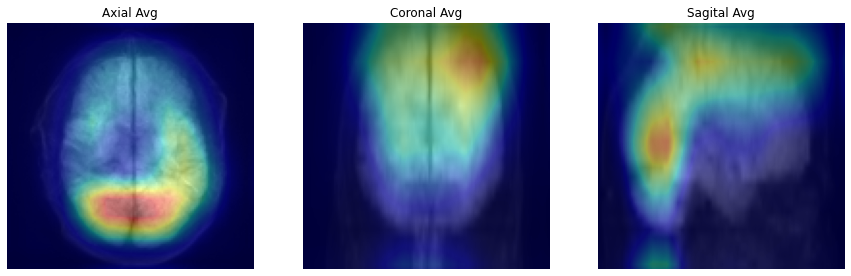

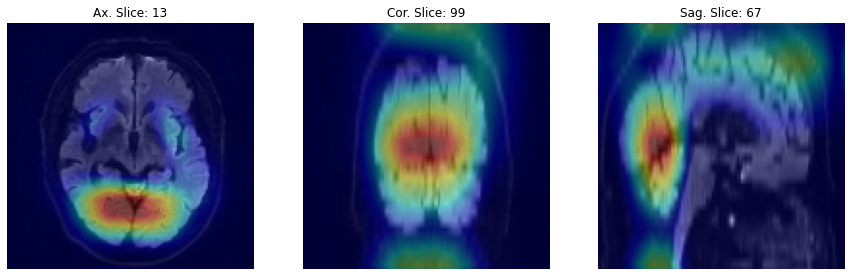

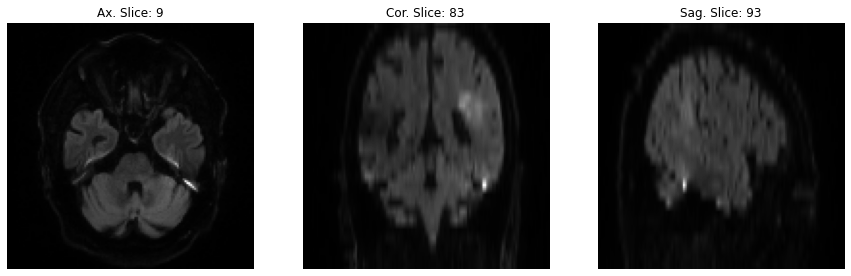

In [12]:
# all models
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = vis_layers[3],
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "last",
    gcpp_hm = "last")

fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
fph.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max",
            orig_max=True)
# fph.plot_gradcam(resized_img, heatmap,
#             version = "original",
#             mode = "def",
#             slices=(78,95,6))

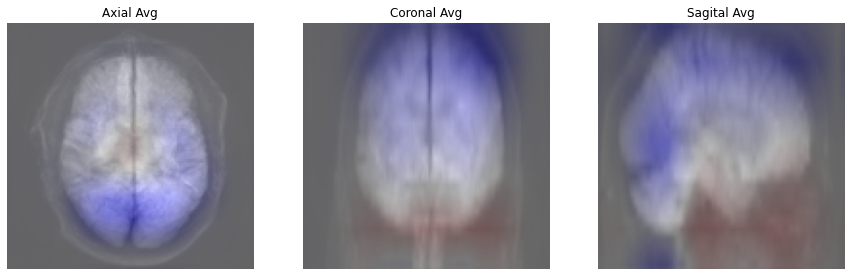

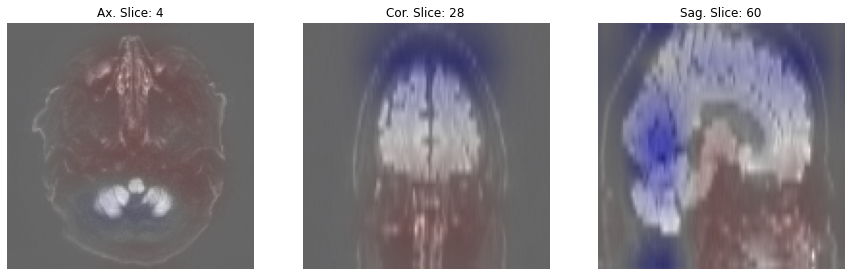

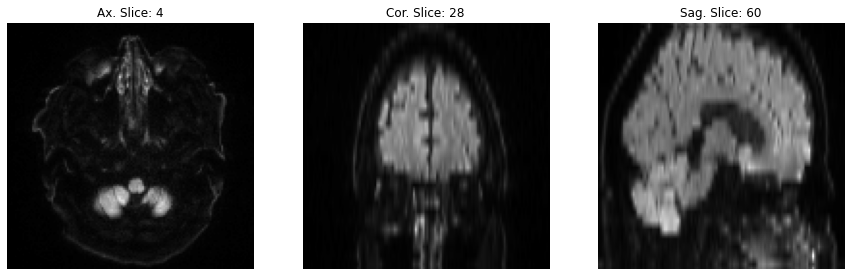

In [13]:

# all models
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = vis_layers[3],
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "none",
    gcpp_hm="none")

fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg", 
            hm_colormap="bwr", hm_positive=False)
fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max", 
            hm_colormap="bwr", hm_positive=False)
fph.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

In [14]:
heatmap.min()

-1.0

## Model Uncertainty Heatmap

In [15]:
heatmaps = []
for i in range(5):
    heatmap0, resized_img, max_hm_slice0, hm_mean_std0 = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = [res_model_names[0][i]],
    layers = "conv3d_3",
    model_mode = "mean")
    print(np.unravel_index(np.argmax(heatmap0), heatmap0.shape))
    heatmaps.append(heatmap0)
heatmaps = np.array(heatmaps)
heatmaps.shape
heatmap_var = np.var(heatmaps, axis = 0)
print(np.sqrt(np.mean(heatmap_var)))

(67, 67, 4, 0)
(28, 59, 4, 0)
(76, 76, 4, 0)
(52, 67, 4, 0)
(28, 67, 4, 0)
0.04861867


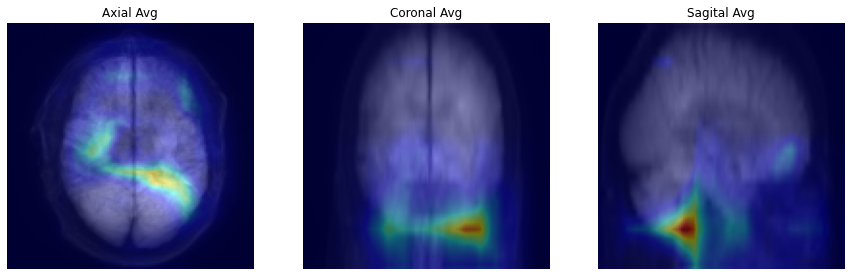

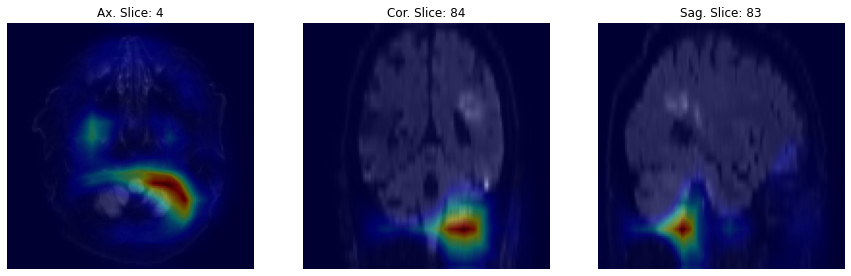

In [16]:
fph.plot_gradcam(resized_img, heatmap_var,
            version = "overlay",
            mode = "avg")
fph.plot_gradcam(resized_img, heatmap_var,
            version = "overlay",
            mode = "max")
# fph.plot_gradcam(resized_img, heatmap,
#             version = "original",
#             mode = "max")

In [17]:
from skimage.metrics import structural_similarity, mean_squared_error, normalized_root_mse

mse = []
ssim = []

for i in range(len(heatmaps)):
    for j in range(len(heatmaps)):
        mse.append(mean_squared_error(heatmaps[i].squeeze(), heatmaps[j].squeeze()))
        ssim.append(structural_similarity(heatmaps[i].squeeze(), heatmaps[j].squeeze(), data_range=1, multichannel = False))
        
print(np.array(mse).reshape((5,5)))
print(np.array(ssim).reshape((5,5)))

[[0.         0.0037241  0.00618303 0.00636513 0.00386372]
 [0.0037241  0.         0.01011722 0.00988898 0.00663426]
 [0.00618303 0.01011722 0.         0.00414541 0.00295588]
 [0.00636513 0.00988898 0.00414541 0.         0.00521663]
 [0.00386372 0.00663426 0.00295588 0.00521663 0.        ]]
[[1.         0.70733242 0.83028524 0.81446864 0.8563501 ]
 [0.70733242 1.         0.67165771 0.65279808 0.69409508]
 [0.83028524 0.67165771 1.         0.84001651 0.89034031]
 [0.81446864 0.65279808 0.84001651 1.         0.80794506]
 [0.8563501  0.69409508 0.89034031 0.80794506 1.        ]]


## Plot multiple Layers

In [18]:
# select patient
p_ids = [12]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)
res_table

index  p_idx  p_id  mrs  unfavorable  fold0  fold1  fold2  fold3 fold4  \
0    267      8    12  1.0            0  train  train  train  train   val   

   ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
0  ...        0.034947        0.027274        0.051183          0.039689   

  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  \
0         0.038801   0.240781             0    0.009389    0.030593   

   pred_correct  
0          True  

[1 rows x 28 columns]

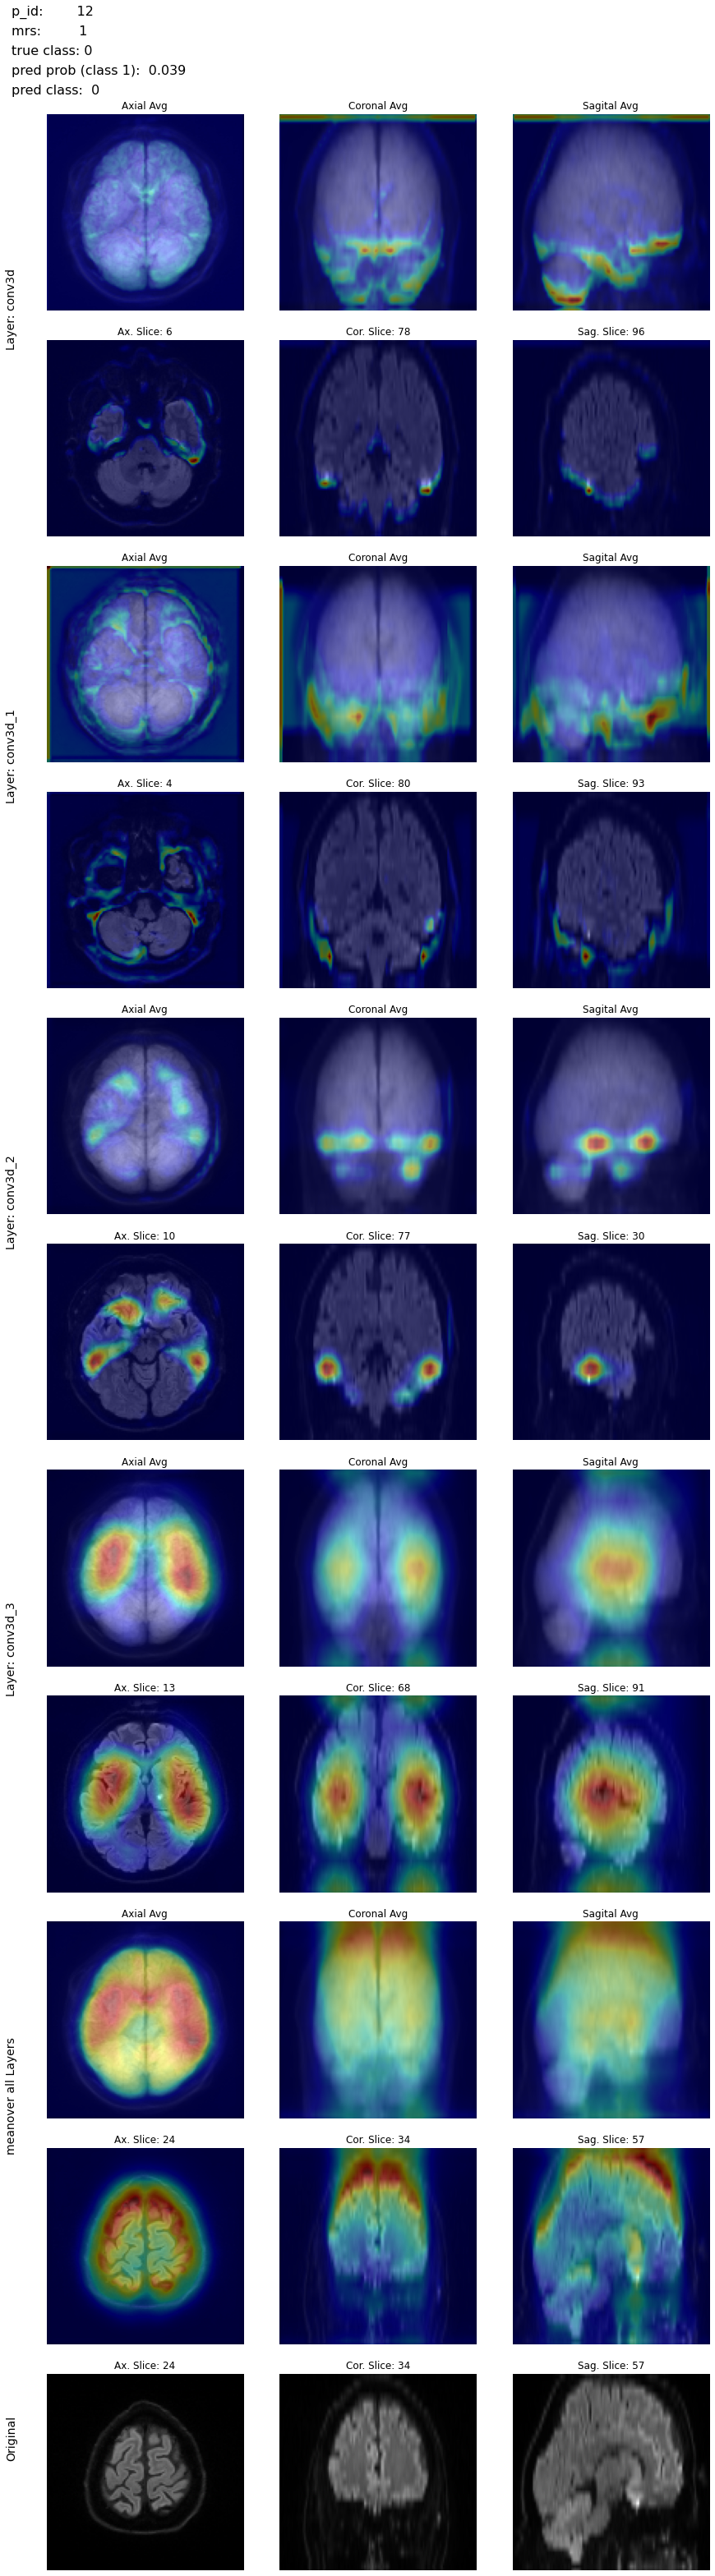

In [19]:
model_mode = "mean"
layer_mode = "mean"
invert_hm = "last"

vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

if "sigmoid" in str(model_3d.layers[-1].activation):
        pred_idx = 0
elif "softmax" in str(model_3d.layers[-1].activation):
        pred_idx = 1

for j in range(len(res_table)):   
    plot_per_iter = 2
    plot_at_end = 1
    num_rows = len(vis_layers)*plot_per_iter + plot_per_iter + plot_at_end
    width = 15
    
    start_text = 0.12
    end_text = 0.88
    text_pos = np.flip(np.linspace(
        start_text+(plot_at_end/num_rows)+0.6/(num_rows-plot_at_end), 
        end_text-0.6/(num_rows-plot_at_end), 
        len(vis_layers)+1))
    
    fig = plt.figure(figsize = (width,num_rows*width/3))
    
    plt.gcf().text(0.1, end_text+5/num_rows/15, "p_id:        " + str(round(res_table["p_id"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+4/num_rows/15, "mrs:         " + str(round(res_table["mrs"][j])), fontsize=16)
    plt.gcf().text(0.1, end_text+3/num_rows/15, "true class: " + str(res_table["unfavorable"][j]), fontsize=16)
    plt.gcf().text(0.1, end_text+2/num_rows/15, "pred prob (class 1):  " + str(round(res_table["y_pred_trafo_avg"][j], 3)), fontsize=16)
    plt.gcf().text(0.1, end_text+1/num_rows/15, "pred class:  " + str(res_table["y_pred_class"][j]), fontsize=16)

    for i, vis_layer in enumerate(vis_layers):
#         print("Layer: ", vis_layer)
        plt.gcf().text(0.1, text_pos[i], "Layer: " + vis_layer, 
                       horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    
        heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layer,
            model_mode = model_mode,
            pred_index = pred_idx,
            invert_hm = invert_hm)
        
        fph.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "avg",
                     add_plot = (i*2,num_rows),
                     show = False)
        fph.plot_gradcam(resized_img, heatmap,
                     version = "overlay",
                     mode = "max",
                     add_plot = (i*2+1,num_rows),
                     show = False)
        
    # average over all layers
    heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
            img = res_images[j:j+1], 
            cnn = model_3d,
            model_names = res_model_names[j],
            layers = vis_layers,
            model_mode = model_mode,
            pred_index = pred_idx,
            invert_hm = invert_hm)
    
#     print(layer_mode, "over all Layers")
    plt.gcf().text(0.1, text_pos[-1], layer_mode + "over all Layers", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    fph.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                add_plot = (num_rows-3,num_rows),
                show = False)
    fph.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "max",
                add_plot = (num_rows-2,num_rows),
                show = False)
    
#     print("Original")
    plt.gcf().text(0.1, start_text+(plot_at_end/num_rows)/2, "Original", 
                   horizontalalignment='center', verticalalignment='center', fontsize=14, rotation = 90)
    fph.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "max",
                add_plot = (num_rows-1,num_rows),
                show = False)
    
    plt.subplots_adjust(wspace=0.05, hspace=0.15)
    if save_plot:
        plt.savefig('pictures/p' + str(round(res_table["p_id"][j])) + '_' + pic_save_name + '_all_conv_layers.png')


## Plot last conv and average of conv layer

Same style as PowerPoint

In [20]:
all_results

p_idx  p_id  mrs  unfavorable  fold0  fold1  fold2  fold3  fold4  fold5  \
237      1     1  1.0            0  train  train  train    val  train  train   
120      2     2  1.0            0  train  train  train  train   test  train   
238      3     3  0.0            0  train  train  train    val  train  train   
239      4     5  0.0            0  train  train  train    val  train  train   
0        5     6  3.0            1   test  train  train  train  train    val   
..     ...   ...  ...          ...    ...    ...    ...    ...    ...    ...   
58     392   539  1.0            0  train   test  train  train  train  train   
89     393   540  2.0            0  train  train   test  train  train  train   
29     394   541  0.0            0   test  train  train  train  train    val   
149    395   542  1.0            0  train  train  train  train   test  train   
59     396   544  1.0            0  train   test  train  train  train  train   

     ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
237  ...        0.225657        0.238935        0.238855          0.233893   
120  ...        0.047887        0.161724        0.080574          0.116755   
238  ...        0.215078        0.230941        0.228632          0.226448   
239  ...        0.221537        0.234562        0.234974          0.231038   
0    ...        0.316242        0.210725        0.228032          0.228860   
..   ...             ...             ...             ...               ...   
58   ...        0.235187        0.315802        0.279838          0.296943   
89   ...        0.242043        0.356276        0.376062          0.335027   
29   ...        0.194216        0.107949        0.126793          0.158930   
149  ...        0.180415        0.309532        0.364905          0.329155   
59   ...        0.104980        0.122496        0.061413          0.126786   

     y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  \
237          0.233858   0.240781             0    0.005467    0.012478   
120          0.107362   0.240781             0    0.049707    0.216806   
238          0.226394   0.240781             0    0.006469    0.017104   
239          0.230998   0.240781             0    0.005668    0.013406   
0            0.224606   0.240781             0    0.058630    0.258022   
..                ...        ...           ...         ...         ...   
58           0.295011   0.240781             1    0.050413    0.220068   
89           0.332953   0.240781             1    0.053183    0.232860   
29           0.151696   0.240781             0    0.062534    0.276052   
149          0.320663   0.240781             1    0.112732    0.507900   
59           0.119583   0.240781             0    0.048496    0.211214   

     pred_correct  
237          True  
120          True  
238          True  
239          True  
0           False  
..            ...  
58          False  
89          False  
29           True  
149         False  
59           True  

[295 rows x 27 columns]

In [21]:
# select patient
# p_ids = [6]
p_ids = split_6_pats

if version == "andrea":
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results[all_results.test_split == 6], pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # andrea split
elif version == "10Fold":
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # 10 Fold

if save_plot:
    res_table[["p_id", "mrs", "unfavorable", "test_split", "y_pred_model_10", 
               "y_pred_model_11", "y_pred_model_12", "y_pred_model_13", "y_pred_model_14", 
               "y_pred_trafo_avg", "threshold", "y_pred_class", "y_pred_unc"]].to_csv(
        OUTPUT_DIR + "andrea_split6_meta_data.csv",  index=False)

In [22]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]

In [23]:
res_table

index  p_idx  p_id  mrs  unfavorable  fold0  fold1  fold2  fold3 fold4  \
0    267      8    12  1.0            0  train  train  train  train   val   

   ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
0  ...        0.034947        0.027274        0.051183          0.039689   

  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  \
0         0.038801   0.240781             0    0.009389    0.030593   

   pred_correct  
0          True  

[1 rows x 28 columns]

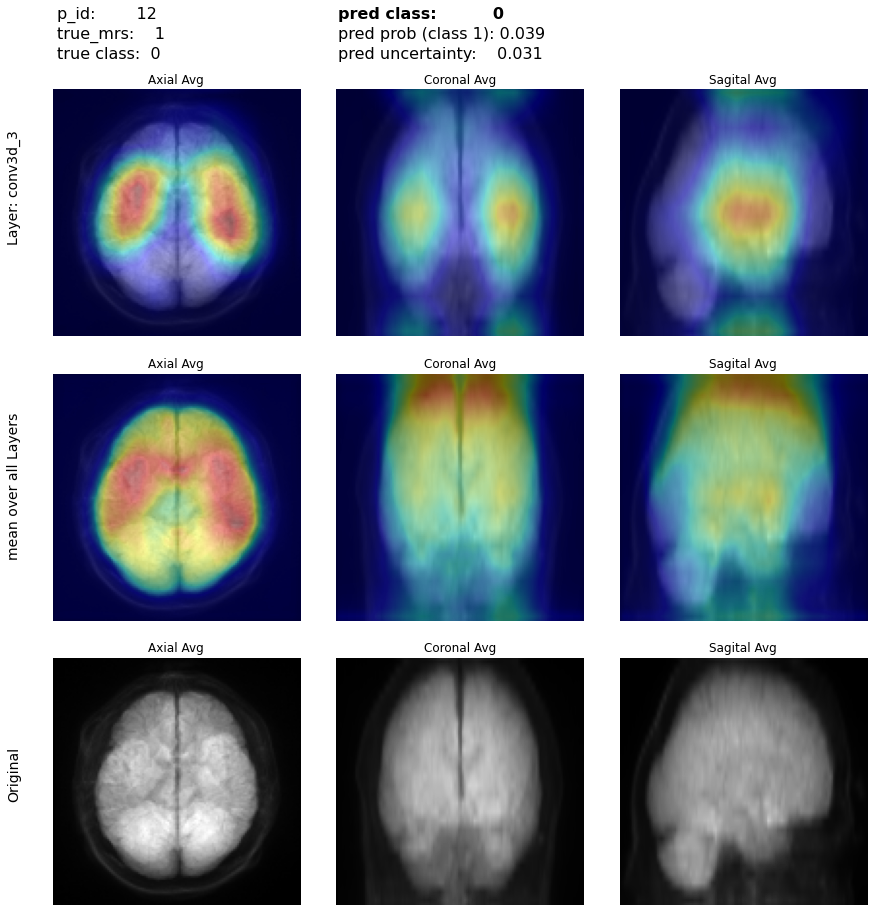

In [24]:
fph.plot_gradcams_last_avg_org(
    res_table = res_table, 
    vis_layers = vis_layers,
    res_images = res_images,
    res_model_names = res_model_names,
    model_3d = model_3d,
    layer_mode = "mean", 
    heatmap_mode = "avg", 
    save_path = OUTPUT_DIR, 
    save_name = pic_save_name, save = save_plot)

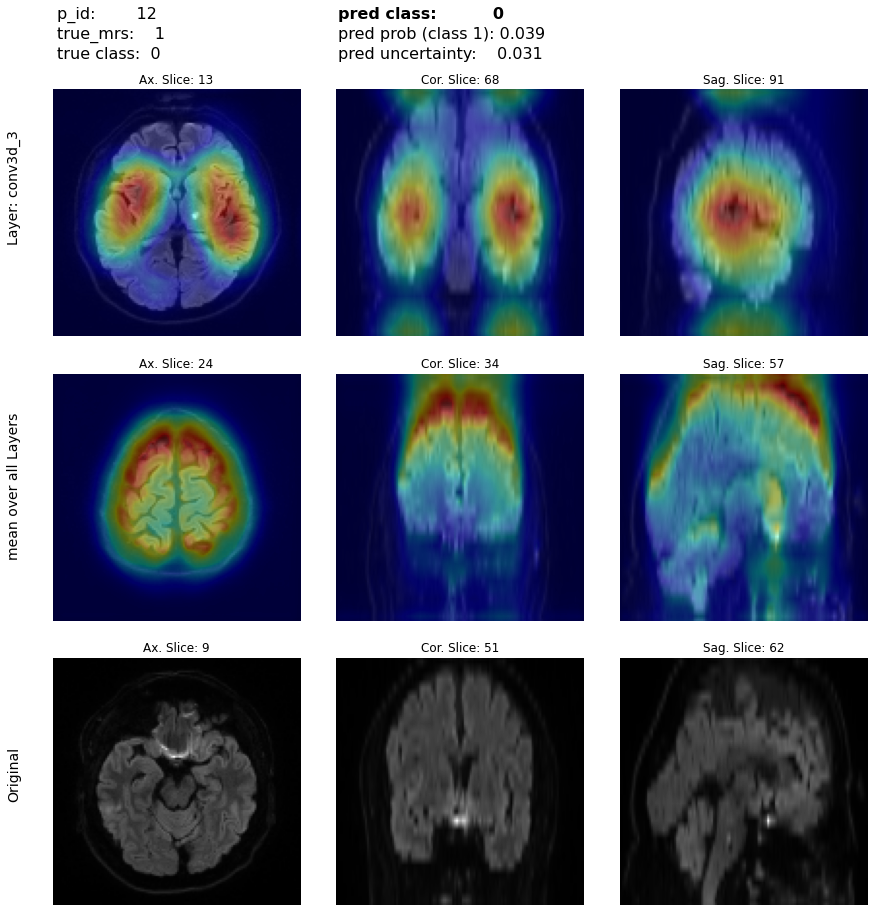

In [25]:
fph.plot_gradcams_last_avg_org(
    res_table = res_table, 
    vis_layers = vis_layers,
    res_images = res_images,
    res_model_names = res_model_names,
    model_3d = model_3d,
    layer_mode = "mean", 
    heatmap_mode = "max", 
    save_path = OUTPUT_DIR, 
    save_name = pic_save_name, save = save_plot)

## Analysis of Patients in multiple splits

In [26]:
all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
all_dup

Empty DataFrame
Columns: [p_idx, p_id, mrs, unfavorable, fold0, fold1, fold2, fold3, fold4, fold5, fold6, fold7, fold8, fold9, test_split, y_pred_model_10, y_pred_model_11, y_pred_model_12, y_pred_model_13, y_pred_model_14, y_pred_linear_avg, y_pred_trafo_avg, threshold, y_pred_class, y_pred_std, y_pred_unc, pred_correct]
Index: []

[0 rows x 27 columns]

In [27]:
p_ids = [9,24]

In [28]:
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)

In [29]:
res_table

index  p_idx  p_id  mrs  unfavorable  fold0  fold1  fold2  fold3  fold4  \
0    150      7     9  0.0            0    val  train  train  train  train   
1     61     17    24  2.0            0  train  train   test  train  train   

   ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
0  ...        0.234617        0.189951        0.216787          0.215501   
1  ...        0.074436        0.368164        0.344716          0.256023   

  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  \
0         0.215086   0.240781             0    0.017294    0.067102   
1         0.233662   0.240781             0    0.115763    0.521895   

   pred_correct  
0          True  
1          True  

[2 rows x 28 columns]

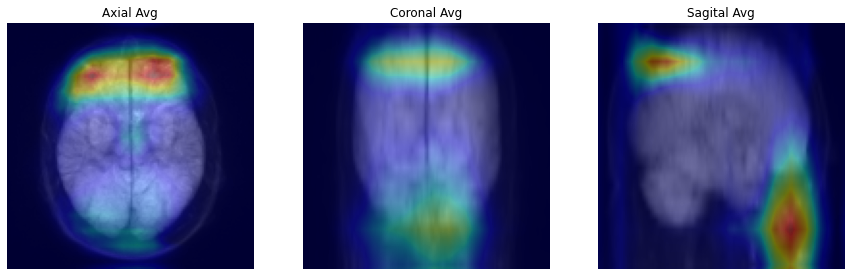

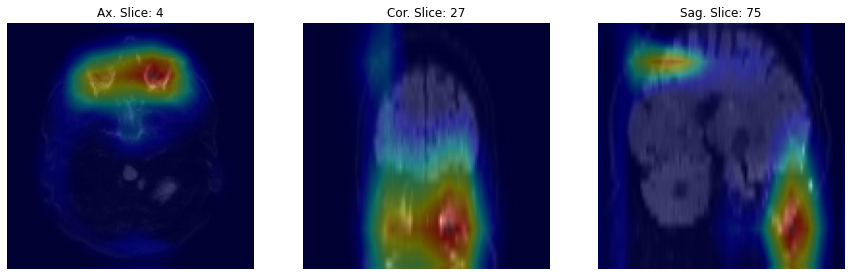

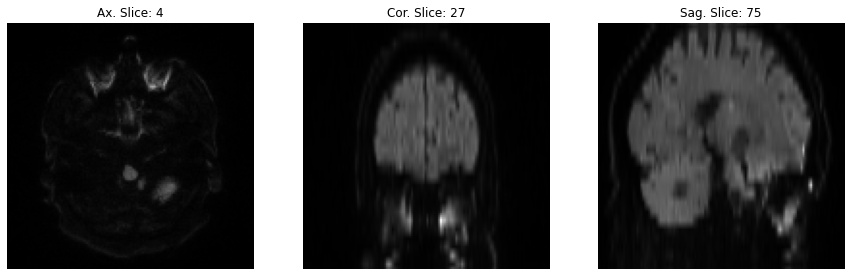

In [30]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    model_mode = "mean")

fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
fph.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

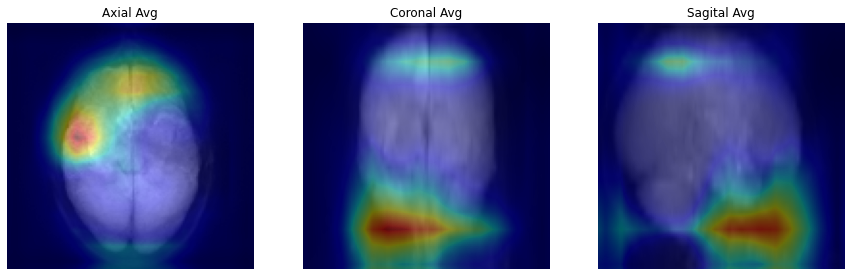

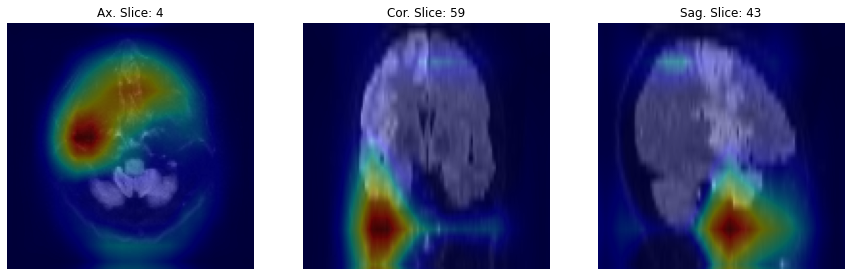

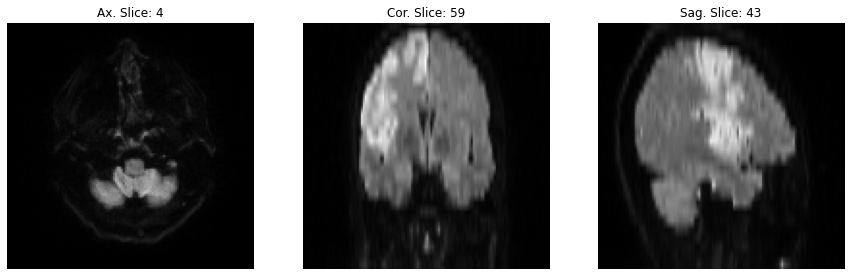

In [31]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[1], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[1],
    layers = "conv3d_3",
    model_mode = "mean")

fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
fph.plot_gradcam(resized_img, heatmap,
            version = "original",
            mode = "max")

## Analyze Image "Impurity"

In [32]:
p_ids = [6]
(res_table, res_images, res_model_names) = gc.get_img_and_models(p_ids, results = all_results, pats = pat, imgs = X_in,
                                                                gen_model_name = generate_model_name)
res_table

index  p_idx  p_id  mrs  unfavorable fold0  fold1  fold2  fold3  fold4  \
0      0      5     6  3.0            1  test  train  train  train  train   

   ... y_pred_model_12 y_pred_model_13 y_pred_model_14 y_pred_linear_avg  \
0  ...        0.316242        0.210725        0.228032           0.22886   

  y_pred_trafo_avg  threshold  y_pred_class  y_pred_std  y_pred_unc  \
0         0.224606   0.240781             0     0.05863    0.258022   

   pred_correct  
0         False  

[1 rows x 28 columns]

In [33]:
new_img = res_images[0].copy()
print(new_img.min(), new_img.max())
new_img[45:60,45:60,10:15] = 8
# new_img[10:20,10:20,10:15] = 4
# new_img += 3

-0.5943586 7.412957


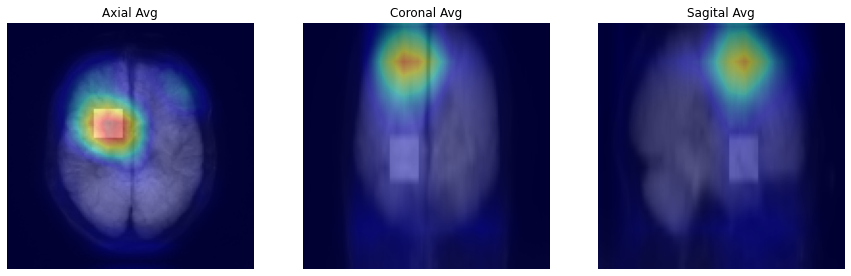

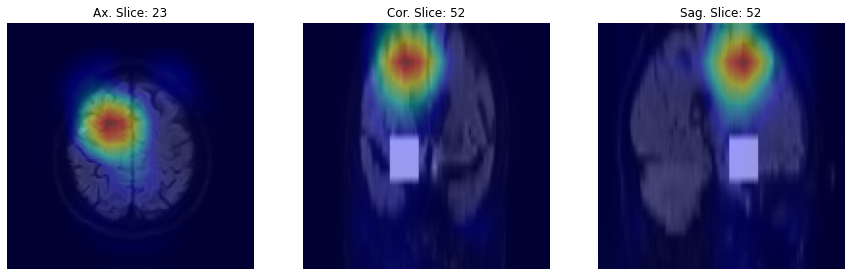

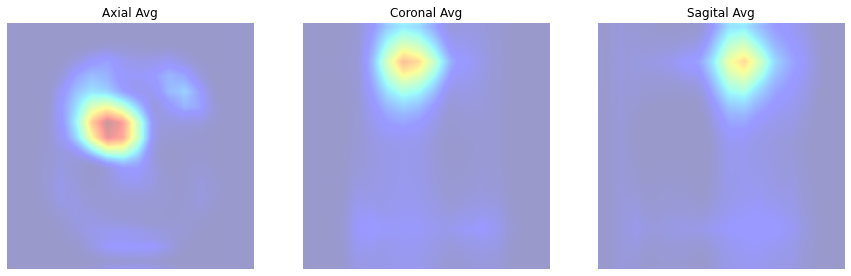

In [34]:
heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(new_img, axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = "conv3d_3",
    model_mode = "mean")

fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "avg")
fph.plot_gradcam(resized_img, heatmap,
            version = "overlay",
            mode = "max")
fph.plot_gradcam(resized_img, heatmap,
            version = "activation",
            mode = "avg")

## Interactive Slicer

In [35]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, Layout, AppLayout
from IPython.display import display
from termcolor import colored
import ipywidgets as widgets

from importlib import reload
reload(pgc)
reload(gc)

def gradcam_interactive_plot(p_id, pred_hm_only=True):
    p_ids = [p_id]
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)
    
    print("patient id: ", res_table.p_id[0])
    print("true mrs: ", res_table.mrs[0])
    print("true class: ", res_table.unfavorable[0])
    print(colored("pred class: "+str(res_table.y_pred_class[0]), 
                'green' if res_table["pred_correct"][0] == True else 'red'))
    print("pred prob (class 1): ", res_table.y_pred_trafo_avg[0])
    print("pred uncertainty: ", res_table.y_pred_unc[0])
    # print("heatmap unc. last layer: ", res_table.y_pred_unc[0])
    
    ## Generate heatmap
    if pred_hm_only:
        invert_hm = "all" if res_table.y_pred_class[0] == 0 else "none"
        gcpp_hm = "last"
        cmap = "jet"
        hm_positive=True
    else:
        invert_hm = "none"
        gcpp_hm = "none"
        cmap = "bwr"
        hm_positive=False
    
            
    heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
        img = np.expand_dims(res_images[0], axis = 0), 
        cnn = model_3d,
        model_names = res_model_names[0],
        layers = vis_layers[3],
        model_mode = "mean",
        pred_index = 0,
        invert_hm = invert_hm,
        gcpp_hm = gcpp_hm)

    slices = np.unravel_index(heatmap.argmax(), heatmap.shape)
    print("max slices:", (slices[2], slices[0], slices[1]))
    
    ## Plot Heatmap Average
    fph.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)

    ## Plot Heatmap Slider
    def slicer(axi_slider, cor_slider, sag_slider):
        fph.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "def",
                slices = (cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)
        fph.plot_gradcam(resized_img, heatmap,
                version = "original",
                mode = "def",
                slices=(cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                slice_line=True)

    w=interactive(
        slicer, 
        axi_slider=widgets.IntSlider(value=slices[2],min=0,max=27,step=1), 
        cor_slider=widgets.IntSlider(value=slices[0],min=0,max=127,step=1), 
        sag_slider=widgets.IntSlider(value=slices[1],min=0,max=127,step=1))

    slider_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='9.2in')
    images_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='15', height='15')

    display(VBox([
        HBox([w.children[0],w.children[1], w.children[2]], layout=slider_layout),
        HBox([w.children[3]], layout=images_layout)
    ]))      
    w.update()

patient id:  284
true mrs:  1.0
true class:  0
pred class: 0
pred prob (class 1):  0.23239268
pred uncertainty:  0.15009597
max slices: (13, 75, 92)


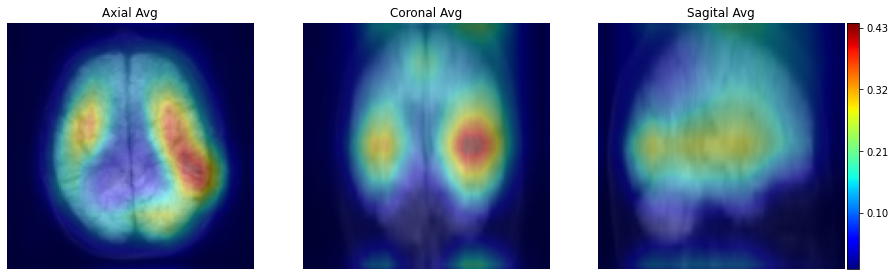

In [46]:
gradcam_interactive_plot(284, pred_hm_only=True)


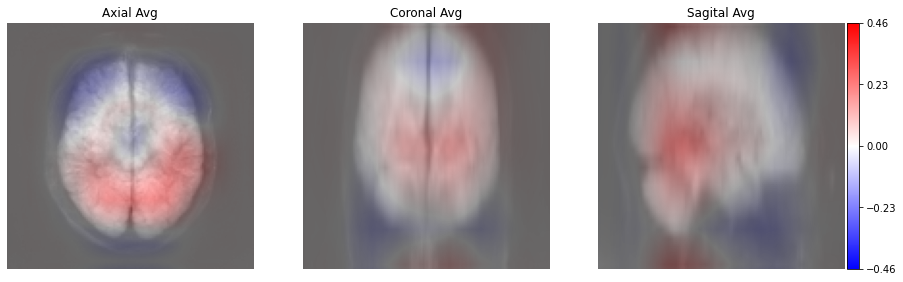

In [37]:
from importlib import reload
reload(pgc)

heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
    img = np.expand_dims(res_images[0], axis = 0), 
    cnn = model_3d,
    model_names = res_model_names[0],
    layers = vis_layers[3],
    model_mode = "mean",
    pred_index = 0,
    invert_hm = "all",
    gcpp_hm="none")

fph.plot_gradcam(resized_img, heatmap,
                version = "overlay",
                mode = "avg",
                hm_colormap="bwr",
                hm_positive=False,
                colorbar=True)